![](data/banner.png)
# Objetivos
+ Comprender y análizar los datos del dataset de emociones
+ Preprocesar los datos con distintas técnicas (limpieza, tokenización, normalización y representación)

# Librerias

In [1]:
import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

# Para trabajar los datos
import pandas as pd
import numpy as np

# Para visualizar los datos
import matplotlib.pyplot as plt
import seaborn as sns

#Para analizar sentimientos
from textblob import TextBlob

# Para la nube
from wordcloud import WordCloud

# Perfilamiento y entendimiento de los datos

In [2]:
# Cargamos el dataset
file = "train"
df=pd.read_csv(f'data/{file}.csv', sep=';', encoding = 'utf-8', names = ["Text","Emotion"])

In [3]:
# Pre visualización
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
# Shape
df.shape

(16000, 2)

In [5]:
# Datatypes
df.dtypes

Text       object
Emotion    object
dtype: object

In [6]:
# Revisamos valores nulos
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [7]:
# Realizamos un conteo de emociones
df["Emotion"].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

<AxesSubplot:xlabel='Emotion', ylabel='count'>

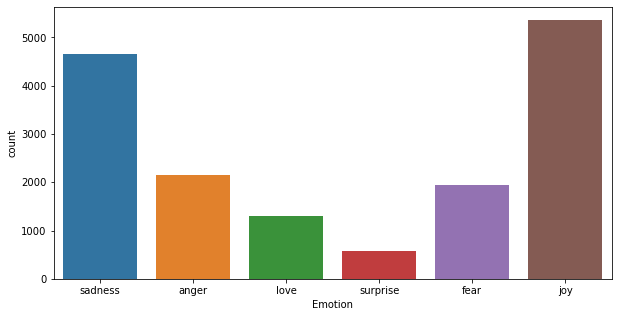

In [8]:
# Vizualizamos el conteo de emociones
plt.figure(figsize=(10,5))
sns.countplot(x = "Emotion", data = df)

In [9]:
# Análisis de sentimientos
def get_sentiment(text):
    blob =TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        result = "Positive"
    elif sentiment < 0:
        result = "Negative"
    else:
        result = "Neutral"
    return result

In [10]:
#Ejemplo negativo
get_sentiment("I hate working on sunday")

'Negative'

In [11]:
#Ejemplo neutro
get_sentiment("A frie is a potatoe")

'Neutral'

In [12]:
#Ejemplo positivo
get_sentiment("I love Brenda")

'Positive'

In [13]:
df_sentiment = df[["Text", "Emotion"]]
df_sentiment["Sentiment"] = df["Text"].apply(lambda x: get_sentiment(x))

In [14]:
df_sentiment.head()

,Text,Emotion,Sentiment
0,i didnt feel humiliated,sadness,Neutral
1,i can go from feeling so hopeless to so damned...,sadness,Neutral
2,im grabbing a minute to post i feel greedy wrong,anger,Negative
3,i am ever feeling nostalgic about the fireplac...,love,Negative
4,i am feeling grouchy,anger,Neutral


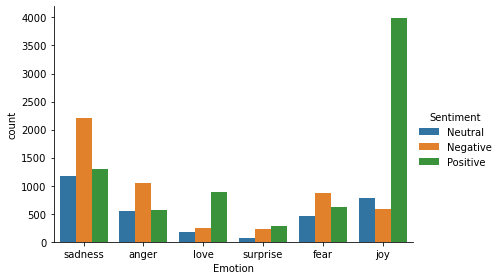

In [15]:
# Plot Emotion vs Sentiment with seaborn
sns.catplot(x='Emotion', hue="Sentiment", data=df_sentiment, kind="count", height = 4, aspect = 1.5)

# Preparación de datos

## Tokenización
Dividimos la frase en tokens o palabras

In [16]:
# Primero aplicamos la corrección de las contracciones (you're -> you are) después no podremos hacer esto
df['Text'] = df['Text'].apply(contractions.fix) 

In [17]:
# Separa en tokens
df['Words'] = df['Text'].apply(word_tokenize) 
df.head()

,Text,Emotion,Words
0,i did not feel humiliated,sadness,"[i, did, not, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[i, can, go, from, feeling, so, hopeless, to, ..."
2,I am grabbing a minute to post i feel greedy w...,anger,"[I, am, grabbing, a, minute, to, post, i, feel..."
3,i am ever feeling nostalgic about the fireplac...,love,"[i, am, ever, feeling, nostalgic, about, the, ..."
4,i am feeling grouchy,anger,"[i, am, feeling, grouchy]"


## Limpieza del texto
En esta sección se quitará o modificará todo lo que se considere como ruido:
+ Caracteres no ascii
+ Se pasará de mayusculas a minusculas
+ Se eliminará la puntuación
+ Se reemplazarán los números
+ Se quitarán las palabras vacias (artículos, pronombres, preposiciones)

In [18]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
    

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [19]:
# Aplica la limpieza
df['Words'] = df['Words'].apply(preprocessing) 
df.head()

,Text,Emotion,Words
0,i did not feel humiliated,sadness,"[feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,I am grabbing a minute to post i feel greedy w...,anger,"[grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,"[feeling, grouchy]"


## Normalización
+ Steaming
+ Lematización

In [20]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [21]:
df['Words'] = df['Words'].apply(stem_and_lemmatize)
df.head()

,Text,Emotion,Words
0,i did not feel humiliated,sadness,"[feel, humy, feel, humiliate]"
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feel, hopeless, damn, hop, around, someon..."
2,I am grabbing a minute to post i feel greedy w...,anger,"[grab, minut, post, feel, greedy, wrong, grab,..."
3,i am ever feeling nostalgic about the fireplac...,love,"[ev, feel, nostalg, fireplac, know, stil, prop..."
4,i am feeling grouchy,anger,"[feel, grouchy, feel, grouchy]"


## dataframe preprocesado

In [22]:
banned = ["feel", "like"]

def remove_banned(words):
    """Remove banned words"""
    new_words = []
    for word in words:
        if word not in banned:
            new_words.append(word)
    return new_words

df['Words'] = df['Words'].apply(remove_banned)

In [23]:
df['processed_message'] = df['Words'].apply(lambda x: ' '.join(map(str, x)))
df.head()

,Text,Emotion,Words,processed_message
0,i did not feel humiliated,sadness,"[humy, humiliate]",humy humiliate
1,i can go from feeling so hopeless to so damned...,sadness,"[go, hopeless, damn, hop, around, someon, car,...",go hopeless damn hop around someon car awak go...
2,I am grabbing a minute to post i feel greedy w...,anger,"[grab, minut, post, greedy, wrong, grab, minut...",grab minut post greedy wrong grab minute post ...
3,i am ever feeling nostalgic about the fireplac...,love,"[ev, nostalg, fireplac, know, stil, property, ...",ev nostalg fireplac know stil property ever no...
4,i am feeling grouchy,anger,"[grouchy, grouchy]",grouchy grouchy


In [24]:
# Guardamos el resultado del preprocesamiento
df[["Emotion", "processed_message"]].to_csv(f'data/{file}_preprocessed.csv')

# Resultados del preprocesamiento
Revisaremos que tokens o palabras son significativas para cada emoción

In [25]:
from collections import Counter

In [26]:
# Lista de emociones
emotion_list = df["Emotion"].unique().tolist()

In [27]:
emotion_list

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

In [28]:
def generate_docx(df,emotion):
    """Gets a string of all text of an emotion"""
    mylist = df[df["Emotion"] == emotion]["processed_message"].tolist()
    mydocx = ''.join(mylist)
    return mydocx

In [29]:
sadness_docx = generate_docx(df,"sadness")
joy_docx = generate_docx(df,"joy")
fear_docx = generate_docx(df,"fear")
anger_docx = generate_docx(df,"anger")
love_docx = generate_docx(df,"love")
surprise_docx = generate_docx(df,"surprise")

In [30]:
def extract_keywords(text, num = 50):
    """Gets a dictionary with the # of ocurrences of a word"""
    tokens = [token for token in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

In [31]:
keyword_sadness = extract_keywords(sadness_docx)
keyword_joy = extract_keywords(joy_docx)
keyword_fear = extract_keywords(fear_docx)
keyword_anger = extract_keywords(anger_docx)
keyword_love = extract_keywords(love_docx)
keyword_surprise = extract_keywords(surprise_docx)

In [32]:
# Plot
def plot_most_common_words(mydict, emotion_name):
    df_01 = pd.DataFrame(mydict.items(),columns=["token","count"])
    plt.figure(figsize=(10,5))
    plt.title("Plot of {}".format(emotion_name))
    sns.barplot(x = 'token', y="count", data = df_01)
    plt.xticks(rotation=90)
    plt.show()

In [33]:
def plot_wordcloud(docx):
    mywordcloud = WordCloud().generate(docx)
    plt.figure(figsize=(10,5))
    plt.imshow(mywordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Sadness

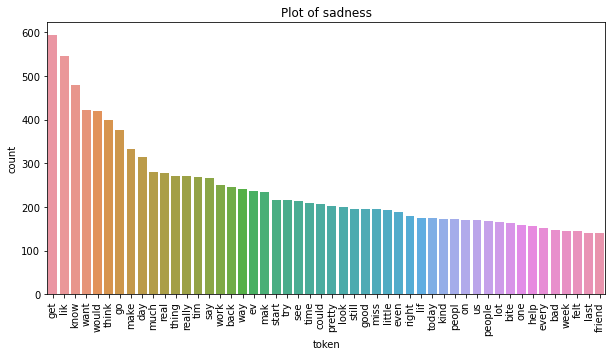

In [34]:
plot_most_common_words(keyword_sadness,"sadness")

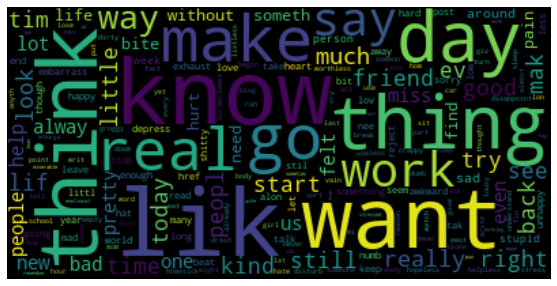

In [35]:
plot_wordcloud(sadness_docx)

## Joy

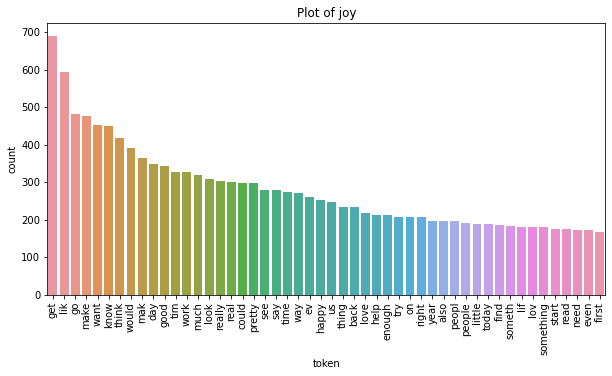

In [36]:
plot_most_common_words(keyword_joy,"joy")

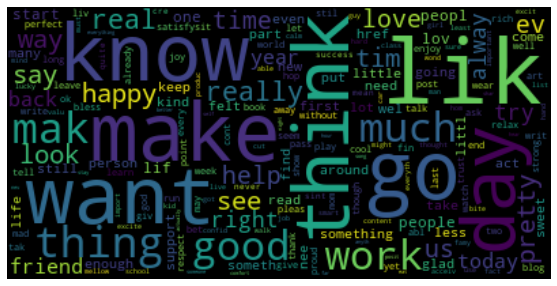

In [37]:
plot_wordcloud(joy_docx)

## Fear

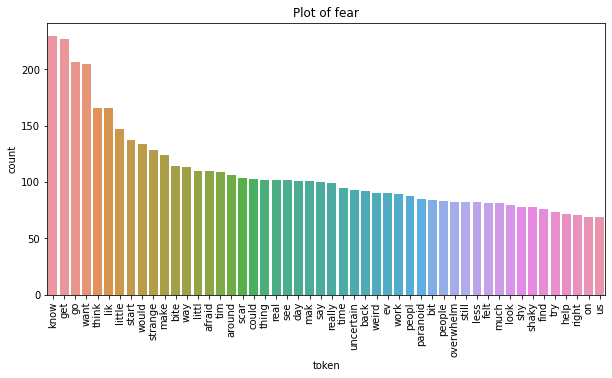

In [38]:
plot_most_common_words(keyword_fear,"fear")

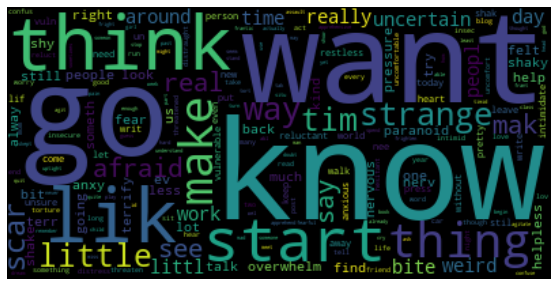

In [39]:
plot_wordcloud(fear_docx)

## Anger

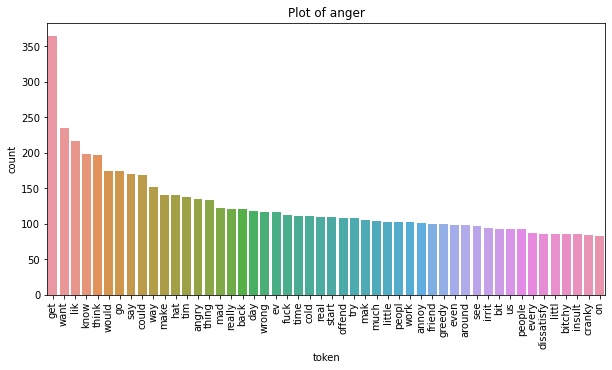

In [40]:
plot_most_common_words(keyword_anger,"anger")

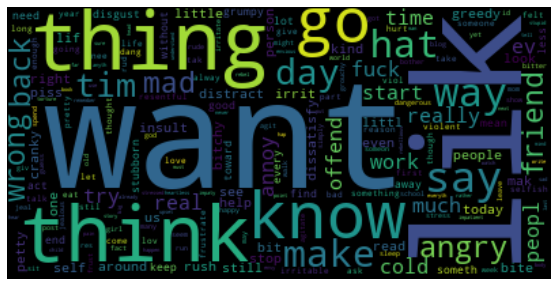

In [41]:
plot_wordcloud(anger_docx)

## Love

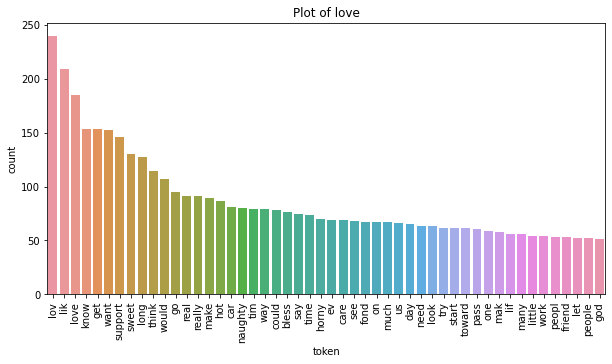

In [42]:
plot_most_common_words(keyword_love,"love")

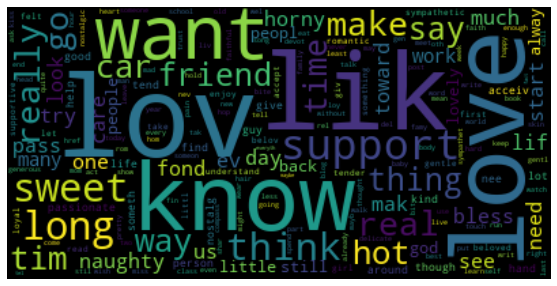

In [43]:
plot_wordcloud(love_docx)

## Surprise

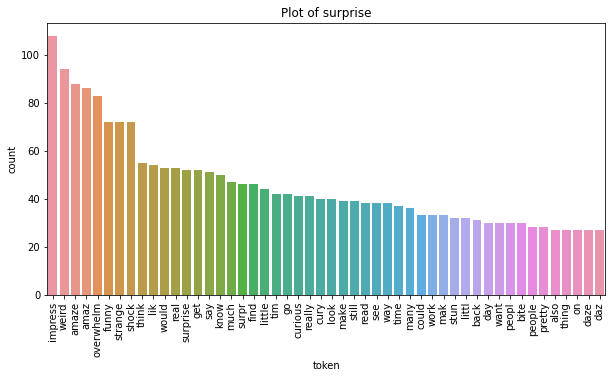

In [44]:
plot_most_common_words(keyword_surprise,"surprise")

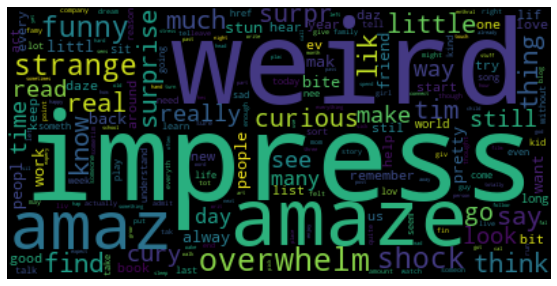

In [45]:
plot_wordcloud(surprise_docx)